In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

In [2]:
df = pd.read_csv("pycnogonida_taxa.csv")
pycnogonida = df[(df['rank'] == 'Species') & (df['status'] == 'accepted') & (df['isExtinct'].isna() | (df['isExtinct'] == 0))].reset_index(drop=True)

all_occurrences = dict()

occurrencies_df_names = [df for df in os.listdir('occurrencies') if df.endswith('tsv')]

for occurrencies_df_name in occurrencies_df_names:
    all_occurrences[occurrencies_df_name[0].upper() + occurrencies_df_name.split('.')[0].replace('_', ' ')[1:]] = pd.read_csv('occurrencies/{}'.format(occurrencies_df_name), sep = '\t')

In [3]:
# Function to extract year from the authority string
def extract_year(authority):
    # Look for four consecutive digits which typically represent a year in the authority text
    match = re.search(r'\b(1[5-9]\d\d|20[0-1]\d|202[0-3])\b', authority)
    if match:
        return int(match.group(0))
    else:
        return None

In [4]:
# Apply the function to the authority column to extract year
pycnogonida['year_described'] = pycnogonida['authority'].apply(extract_year)

# Drop rows where year is None (missing data)
data_with_years = pycnogonida.dropna(subset=['year_described'])

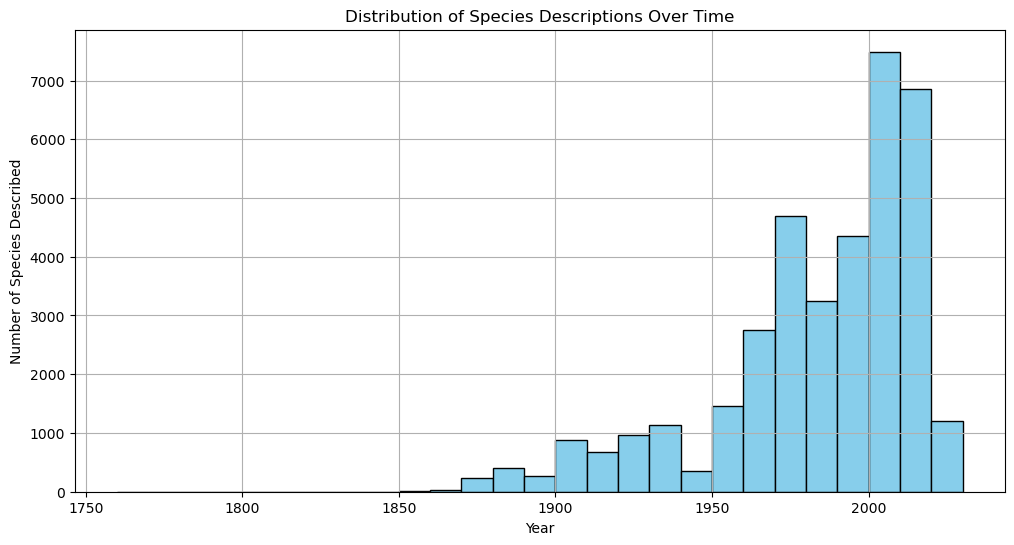

In [5]:
sight_years = list()

for species, occurrences in all_occurrences.items():
    if 'year' in occurrences.columns:
        sight_years.extend(occurrences['year'].dropna().values.tolist())

# Create a histogram to show the distribution of species descriptions over time
plt.figure(figsize=(12, 6))
plt.hist(sight_years, bins=range(1760, 2040, 10), color='skyblue', edgecolor='black')
plt.title('Distribution of Species Descriptions Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Species Described')
plt.grid(True)
plt.show()

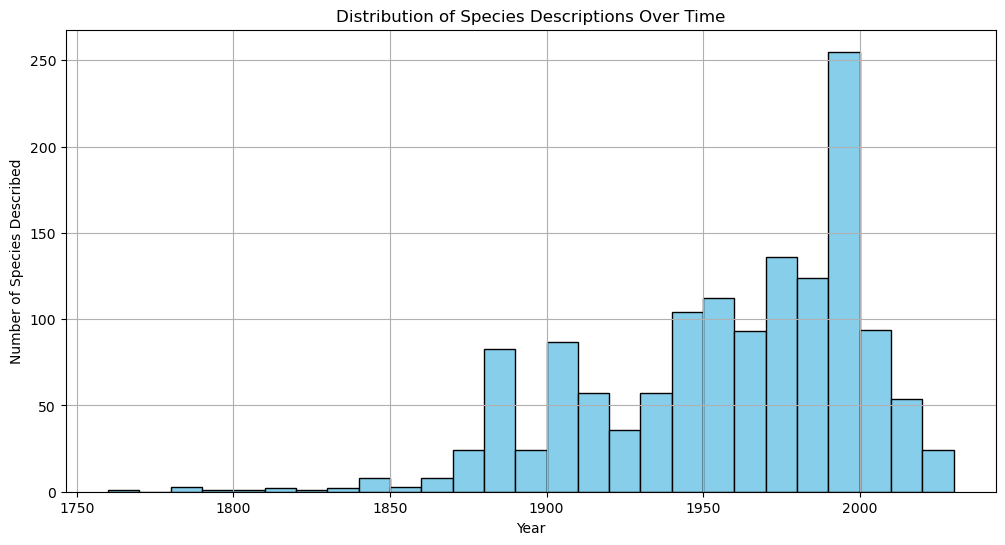

In [6]:
# Create a histogram to show the distribution of species descriptions over time
plt.figure(figsize=(12, 6))
plt.hist(data_with_years['year_described'], bins=range(1760, 2040, 10), color='skyblue', edgecolor='black')
plt.title('Distribution of Species Descriptions Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Species Described')
plt.grid(True)
plt.show()

In [7]:
species = 'Callipallene californiensis'

# Filtra le occorrenze per quelle che hanno coordinate valide
valid_occurrences = pd.DataFrame(all_occurrences[species]).dropna(subset=['decimalLatitude', 'decimalLongitude'])

# Crea una mappa centrata sulle coordinate medie
m = folium.Map(location=[valid_occurrences['decimalLatitude'].mean(), valid_occurrences['decimalLongitude'].mean()], zoom_start=2)

# Aggiungi i punti alla mappa
for _, occurrence in valid_occurrences.iterrows():
    if pd.isna(occurrence['year']):
        sight_y = 'ND'
    else:
        sight_y = int(occurrence['year'])

    folium.Marker(
        location=[occurrence['decimalLatitude'], occurrence['decimalLongitude']],
        popup="{}\nYear: {}".format(occurrence['acceptedScientificName'], sight_y),
    ).add_to(m)

# Salva la mappa in un file HTML
m.save('{}_map.html'.format(species.lower().replace(' ', '_')))

In [8]:
# Prepariamo un DataFrame per tutte le segnalazioni valide
all_valid_occurrences = []

# Itera su ogni specie nel dizionario all_occurrences
for species, occurrences in all_occurrences.items():
    # Verifica la presenza delle colonne necessarie prima del filtraggio
    if 'decimalLatitude' in occurrences.columns and 'decimalLongitude' in occurrences.columns:
        # Filtra le occorrenze per quelle che hanno coordinate valide
        valid_df = occurrences.dropna(subset=['decimalLatitude', 'decimalLongitude'])
        # Aggiungi le occorrenze valide alla lista generale
        all_valid_occurrences.append(valid_df)

# Verifica se abbiamo raccolto qualche DataFrame valido
if all_valid_occurrences:
    # Concatena tutti i DataFrame in uno solo
    all_valid_occurrences = pd.concat(all_valid_occurrences, ignore_index=True)

    # Crea una mappa centrata su una vista globale
    m = folium.Map(
        location=[0, 0],
        zoom_start=2,
        tiles='CartoDB dark_matter',  # Utilizzo di uno sfondo dark
        attr='Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL'  # Attribuzione necessaria
    )

    # Prepara i dati per la heatmap
    heatmap_data = all_valid_occurrences[['decimalLatitude', 'decimalLongitude']].values.tolist()

    # Aggiungi la heatmap alla mappa
    HeatMap(
        heatmap_data,
        radius=7.5,
        min_opacity=0.5,
        max_opacity=1,
        blur=5,
        gradient={0.0: 'yellow', 0.5: 'lime', 0.9: 'blue', 1.0 : 'red'}).add_to(m)

    # Salva la mappa in un file HTML
    m.save('global_picnogonids_heatmap.html')
else:
    print("Non sono state trovate segnalazioni valide per la creazione della mappa.")

Accorpare ulteriori informazioni sui picnogonidi può arricchire la tua ricerca e fornire una comprensione più approfondita di questi organismi. Ecco alcuni altri database e risorse che puoi considerare per ottenere informazioni aggiuntive:

### 1. **GenBank (NCBI)**
**Descrizione**: Un database nucleotidico del National Center for Biotechnology Information che contiene sequenze genetiche per vari organismi.
**Informazioni Utili**: Sequenze genetiche, informazioni genomiche, annotazioni funzionali.
**Accesso**: [GenBank](https://www.ncbi.nlm.nih.gov/genbank/)

### 2. **BOLD Systems (Barcode of Life Data System)**
**Descrizione**: Un database che fornisce dati di codici a barre del DNA per l'identificazione delle specie.
**Informazioni Utili**: Sequenze di codici a barre del DNA, informazioni tassonomiche, dati geografici.
**Accesso**: [BOLD Systems](http://www.boldsystems.org/)

### 3. **FishBase**
**Descrizione**: Un database globale completo di informazioni su tutte le specie di pesci conosciute, incluse alcune specie marine invertebrate come i picnogonidi.
**Informazioni Utili**: Informazioni ecologiche, distribuzione geografica, dati di cattura, informazioni su habitat e conservazione.
**Accesso**: [FishBase](https://www.fishbase.se/)

### 4. **Ocean Biogeographic Information System (OBIS)**
**Descrizione**: Una rete internazionale di dati di biodiversità marina.
**Informazioni Utili**: Distribuzione delle specie marine, dati di presenza, informazioni ecologiche.
**Accesso**: [OBIS](https://obis.org/)

### 5. **Integrated Taxonomic Information System (ITIS)**
**Descrizione**: Un partnership tra varie agenzie che fornisce informazioni tassonomiche dettagliate.
**Informazioni Utili**: Tassonomia, sinonimi, distribuzione geografica.
**Accesso**: [ITIS](https://www.itis.gov/)

### 6. **Encyclopedia of Life (EOL)**
**Descrizione**: Un database che fornisce informazioni complete su tutte le specie viventi.
**Informazioni Utili**: Descrizioni delle specie, immagini, informazioni sulla distribuzione, dati ecologici.
**Accesso**: [EOL](https://eol.org/)

### 7. **Zooniverse (Citizen Science Projects)**
**Descrizione**: Una piattaforma per progetti di scienza partecipativa che potrebbe avere dati rilevanti provenienti da osservazioni di cittadini.
**Informazioni Utili**: Osservazioni naturalistiche, dati ecologici e comportamentali.
**Accesso**: [Zooniverse](https://www.zooniverse.org/)

### 8. **Global Biodiversity Information Facility (GBIF)**
**Descrizione**: Una rete internazionale che fornisce accesso a dati sulla biodiversità globale. Anche se hai già utilizzato GBIF, esplora se ci sono dataset aggiuntivi o più dettagliati disponibili.
**Informazioni Utili**: Dati di occorrenza, distribuzione, informazioni ecologiche.
**Accesso**: [GBIF](https://www.gbif.org/)

### 9. **PANGAEA (Data Publisher for Earth & Environmental Science)**
**Descrizione**: Un database che archivia e distribuisce dati sulla terra e le scienze ambientali.
**Informazioni Utili**: Dati oceanografici, ecologici, e ambientali.
**Accesso**: [PANGAEA](https://www.pangaea.de/)

### 10. **Marine Species Identification Portal**
**Descrizione**: Un portale per l'identificazione delle specie marine che fornisce informazioni dettagliate sulle specie marine.
**Informazioni Utili**: Descrizioni delle specie, immagini, distribuzione geografica.
**Accesso**: [Marine Species Identification Portal](http://species-identification.org/)

### Strategie per l'Integrazione dei Dati

1. **Automatizzazione delle Richieste API**: Molti di questi database offrono API che puoi utilizzare per automatizzare la raccolta dei dati.
2. **Unificazione dei Dataset**: Dopo aver raccolto i dati, unifica i dataset in un database centrale per facilitarne l'accesso e l'analisi.
3. **Arricchimento dei Dati**: Utilizza gli identificatori univoci (come i codici a barre del DNA) per correlare i dati tra diversi database.

Utilizzando queste risorse, potrai ottenere una visione più completa e dettagliata dei picnogonidi, inclusi aspetti genetici, ecologici, tassonomici e distribuzionali.

In [12]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm

def fetch_genbank_data(species_name):
    # Struttura dati per salvare le informazioni
    species_data = []

    # Step 1: Search for the species in the NCBI nucleotide database
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        'db': 'nucleotide',
        'term': species_name,
        'retmode': 'xml',
        'retmax': '10'  # Adjust the number of results as needed
    }
    search_response = requests.get(search_url, params=search_params)
    search_tree = ET.fromstring(search_response.content)
    id_list = [id_elem.text for id_elem in search_tree.findall(".//Id")]

    for genbank_id in id_list:
        genbank_record = {'GenBank ID': genbank_id}
        
        # Step 2: Fetch summary for each GenBank ID
        summary_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
        summary_params = {
            'db': 'nucleotide',
            'id': genbank_id,
            'retmode': 'xml'
        }
        summary_response = requests.get(summary_url, params=summary_params)
        summary_tree = ET.fromstring(summary_response.content)
        docsum = summary_tree.find(".//DocSum")
        if docsum is not None:
            for item in docsum.findall(".//Item"):
                name = item.get('Name')
                content = item.text
                genbank_record[name] = content

        # Step 3: Fetch detailed information (full record) for each GenBank ID
        fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
        fetch_params = {
            'db': 'nucleotide',
            'id': genbank_id,
            'retmode': 'xml',
            'rettype': 'gb'
        }
        fetch_response = requests.get(fetch_url, params=fetch_params)
        fetch_tree = ET.fromstring(fetch_response.content)
        
        for seq in fetch_tree.findall(".//GBSeq"):
            for child in seq:
                if child.tag == "GBSeq_feature-table":
                    features = []
                    for feature in child:
                        feature_data = {
                            'Feature Key': feature.find('GBFeature_key').text
                        }
                        for qual in feature.findall("GBFeature_quals/GBQualifier"):
                            qual_name = qual.find("GBQualifier_name").text
                            qual_value = qual.find("GBQualifier_value")
                            feature_data[qual_name] = qual_value.text if qual_value is not None else None
                        features.append(feature_data)
                    genbank_record['Features'] = features
                else:
                    genbank_record[child.tag] = child.text

        species_data.append(genbank_record)

    return species_data

In [15]:
from tqdm import tqdm

for species_name in tqdm(pycnogonida["scientificname"], desc='GenBank data retrieving'):
    species_data = fetch_genbank_data(species_name)
    species_df = pd.json_normalize(species_data)
    if not species_df.empty:
        species_df.to_csv('genbank/{}.tsv'.format(species_name.lower().replace(' ', '_')), sep='\t', index=False)

GenBank data retrieving: 100%|██████████| 1394/1394 [2:25:01<00:00,  6.24s/it]  
